<a href="https://colab.research.google.com/github/manu-eldho/artificial_intelligence/blob/main/Forest_cover_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd

data = fetch_covtype(as_frame=True)
df = data.frame

X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

print("Shape:", X.shape)
df.head()

Shape: (581012, 54)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



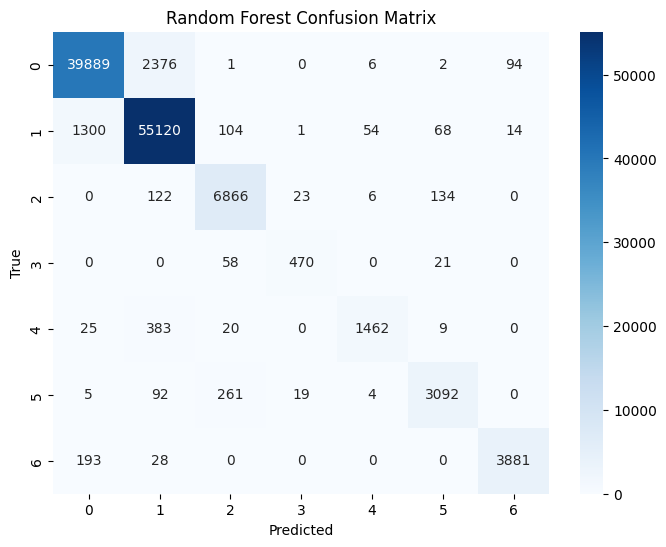

In [5]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

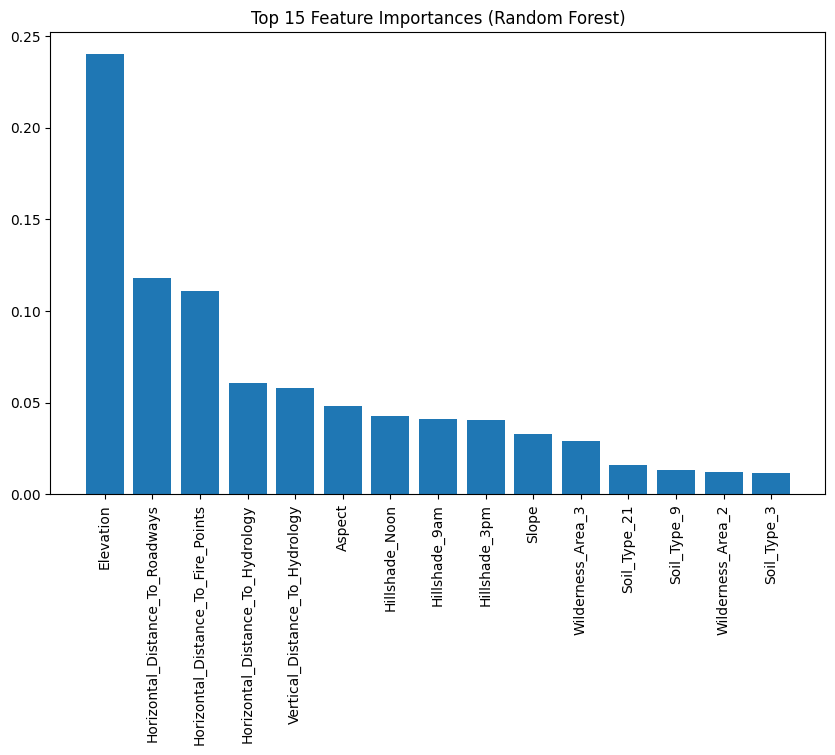

In [7]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), feature_names[indices[:15]], rotation=90)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [9]:
from xgboost import XGBClassifier
import numpy as np

y_train_adj = y_train - 1
y_test_adj = y_test - 1

xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_adj)),  # 7
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train_adj)
y_pred_xgb = xgb.predict(X_test)

# shift back if needed for reporting
from sklearn.metrics import classification_report
print(classification_report(y_test_adj, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:30:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.86      0.84      0.85     42368
           1       0.87      0.90      0.88     56661
           2       0.89      0.91      0.90      7151
           3       0.88      0.86      0.87       549
           4       0.89      0.61      0.72      1899
           5       0.85      0.80      0.82      3473
           6       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2
)

grid_rf.fit(X_train, y_train)
print("Best RF Params:", grid_rf.best_params_)
print("Best RF Score:", grid_rf.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  35.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  41.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  35.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 1.3min
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  39.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  34.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  36.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END max_depth=10, min_samples_split=5, n_es

In [13]:
from sklearn.metrics import accuracy_score

rf_acc = accuracy_score(y_test, y_pred_rf)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")


Random Forest Accuracy: 0.9533
XGBoost Accuracy: 0.0591
